This notebook provides a walk-through for DBP design in Glasscock. et al., 2023. 

### Notebook setup

In [ ]:
import sys,os,json
sys.path.append('/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/')
import tempfile
import numpy as np
import pandas as pd
import pandas
from optparse import OptionParser
import time
import glob
import design_utils
import useful_utils
import seaborn as sns
import string
import random
import pyrosetta
from pyrosetta import *
from pyrosetta.rosetta import *
import pyrosetta.distributed.io as io
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.tasks.score as score
sys.path.append('/projects/protein-DNA-binders/scripts/silent_tools')
import silent_tools
import itertools
import matplotlib.pyplot as plt
import shutil
import subprocess
import math
import jupyter_utils
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import itertools
import sklearn
import re
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neural_network
from sklearn import svm
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.metrics import confusion_matrix,roc_curve,auc
from collections import defaultdict
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

In [3]:
rosetta_db = '/software/rosetta/latest/database'
rosetta_scripts = '/software/rosetta/latest/bin/rosetta_scripts.hdf5.linuxgccrelease'
     
# USER INPUT
ID = 'CGCACCGACTCACG'
user= 'cjg263'
rifdock_path = f'/net/scratch/{user}/de_novo_dna/results/rifdock_stage/rifdock_stage_SEP2022/'
mpnn1_path = f'/net/scratch/{user}/de_novo_dna/results/mpnn_design_stage_1/mpnn1_{ID}_SEP2022/'
inpainting1_path = f'/net/scratch/{user}/de_novo_dna/results/inpainting/inpainting1_{ID}_SEP2022/'
mpnn2_path = f'/net/scratch/{user}/de_novo_dna/results/mpnn_design_stage_2/mpnn2_{ID}_SEP2022/'
mpnn3_path = f'/net/scratch/{user}/de_novo_dna/results/mpnn_design_stage_3/mpnn3_{ID}_SEP2022/'
af2_path = f'/net/scratch/{user}/de_novo_dna/results/af2_superposition/af2_{ID}_SEP2022/'

os.makedirs(mpnn1_path, exist_ok=True)
os.makedirs(inpainting1_path, exist_ok=True)
os.makedirs(mpnn2_path, exist_ok=True)
os.makedirs(mpnn3_path, exist_ok=True)
os.makedirs(af2_path, exist_ok=True)

# Setup various directories
cmds_dir = 'cmds_design'

#shutil.rmtree(cmds_dir)
os.makedirs(cmds_dir, exist_ok=True)

ligandmpnn_apptainer = '/software/containers/users/robpec/PPI_design_mpnn.sif'
ligandmpnn_script = '/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/2b_design_mpnn/mpnn_design.py'

## MPNN Stage 1 Prefilter Calibration

A pilot/predictor run is first used to calibrate prefilters for MPNN stage 1. Follow the steps below to run the pilot on a subset of silent files from RIFdock. The commands below sample 5 RIFdock outputs from each silent file. 

In [4]:
### Get silent files
input_silents = glob.glob(f'{rifdock_path}/{ID}_rifdock_output/*.silent')
print(len(input_silents))

25386


In [6]:
input_silents_rand = random.sample(input_silents,10000)
cmds = f'{mpnn1_path}/cmds_design_prefilter'
os.makedirs(f'{mpnn1_path}/prefilter/',exist_ok=True)
with open(cmds,'w') as f_out:
    n_commands=0
    for silent in input_silents_rand:   
        silent_name = silent.split('/')[-1].replace(".silent","")
        output_dir = f'{mpnn1_path}/prefilter/{silent_name}/'
        os.makedirs(output_dir, exist_ok=True)
        # Build cmd
        cmd = f'cd {output_dir}; \
                {ligandmpnn_apptainer} {ligandmpnn_script} -silent {silent} \
                                -seq_per_struct 1 \
                                -n_per_silent 5 \
                                -temperature 0.1 \
                                -freeze_hbond_resis 0 \
                                -bb_phos_cutoff 1 \
                                -hbond_energy_cut -0.5 \
                                -run_predictor 1 \
                                -run_relax 1\n'
        f_out.write(cmd)
        
env = 'source activate /home/nrbennet/miniconda3/envs/ampere'
if os.path.exists('logs'): shutil.rmtree('logs')
jupyter_utils.make_submit_file(cmds=cmds, env=env, submitfile=cmds+'.sh', group_size=20, queue='cpu-bf', cpus=1, mem='6G')
#p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for clustering in {cmds}')

Prepared and submitted 10000 jobs for clustering in /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_1/mpnn1_CGCACCGACTCACG_SEP2022//cmds_design_prefilter


In [7]:
# Save the ligand specific dataframes
prefilter_dir = f'prefilter_calibration'
os.makedirs(prefilter_dir, exist_ok=True)   

csv_fs = glob.glob(f'{mpnn1_path}/prefilter/*/*.csv')
df = pd.concat([pd.read_csv(f) for f in csv_fs], sort=False)

df.to_csv(f'{mpnn1_path}/prefilter.csv')
print(len(df))

20399


In [3]:
df = pd.read_csv(f'{mpnn1_path}/prefilter.csv')

In [4]:
df['ddg_over_cms'] = df['ddg'] / df['contact_molecular_surface']

In [5]:
df['description'] = df['tag']
predictor_df = df[df['is_prefilter']]
pilot_df = df[~df['is_prefilter']]

predictor_df = predictor_df[predictor_df['ddg'] <= 0]
print(len(predictor_df))
pilot_df = pilot_df[pilot_df['ddg'] <= 0]
print(len(pilot_df))

predictor_df = predictor_df[predictor_df['contact_molecular_surface'] > 10]
print(len(predictor_df))
pilot_df = pilot_df[pilot_df['contact_molecular_surface'] > 10]
print(len(pilot_df))


def suffix_all_columns(df, suffix):
    cols = list(df.columns)
    for i in range(len(cols)):
        cols[i] = cols[i] + suffix
    df.columns = cols 
    
suffix_all_columns(predictor_df, "_pred")
predictor_df['tag'] = predictor_df['tag_pred']

pilot_df = pilot_df.merge(predictor_df, 'inner', 'tag')
#predictor_df['description'] = predictor_df['outpdb']
#pilot_df['description'] = pilot_df['outpdb']

print("Length of predictor dataframe: ", len(predictor_df))
print("Length of pilot dataframe: ", len(pilot_df))

9839
10195
9753
10183
Length of predictor dataframe:  9753
Length of pilot dataframe:  9799


                  ddg_over_cms:  -0.08
     contact_molecular_surface: 225.00

                  ddg_over_cms:    22% pass-rate
     contact_molecular_surface:    38% pass-rate
Orderable: 496   -- 5.06%


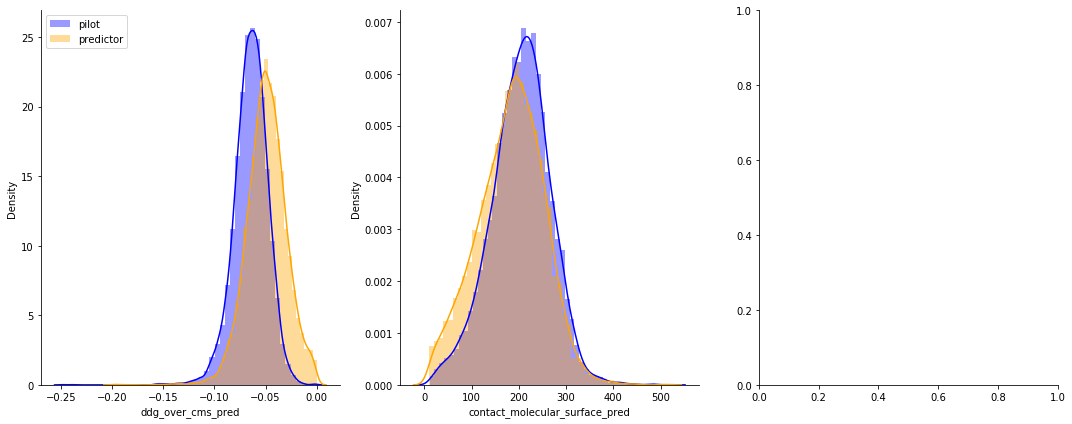

In [8]:
# The format here is:
# Name of the score in pilot, cut value, higher better, name in predictor, is integer score-term

terms_and_cuts = {
    'ddg_over_cms':                      [ -0.076,False, "ddg_over_cms_pred", False],
    'contact_molecular_surface':[225,   True, "contact_molecular_surface_pred", False],
}

pilot_df = pilot_df.dropna(subset=terms_and_cuts.keys())
predictor_df = predictor_df.dropna(subset=[terms_and_cuts[x][2] for x in terms_and_cuts])


score_df = pilot_df

# Filter all the terms and print the thresholds
ok_terms = []
for pilot_term in terms_and_cuts:
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    ok_term = pilot_term.replace("_pilot", "") + "_ok"
    if ( good_high ):
        score_df[ok_term] = score_df[pilot_term] >= cut
    else:
        score_df[ok_term] = score_df[pilot_term] <= cut
    
    ok_terms.append(ok_term)
    
    print("%30s: %6.2f"%(pilot_term, cut))

# Print the pass rates for each term
print("")
score_df['orderable'] = True
for ok_term in ok_terms:
    score_df['orderable'] &= score_df[ok_term]
    print("%30s: %5.0f%% pass-rate"%(ok_term.replace("_ok", ""), score_df[ok_term].sum() / len(score_df) * 100))

# print the overall pass rate   
subdf = score_df
print("Orderable: %i   -- %.2f%%"%(subdf['orderable'].sum(), (100*subdf['orderable'].sum() / len(subdf))))

# Plot and compare to natives
relevant_features  = terms_and_cuts.keys()
ncols = 3
nrows = math.ceil(len(relevant_features) / ncols)
(fig, axs) = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=[15,6*nrows]
)
axs = axs.reshape(-1)

for (i, metric) in enumerate(terms_and_cuts):
    pred_m = terms_and_cuts[metric][2]
#     is_int = terms_and_cuts[metric][3]
#     n_ints = len(set(list(pilot_df[metric])+list(pilot_df[pred_m])))
#     n_bins = n_ints if is_int else None
    sns.distplot(pilot_df[metric], ax=axs[i], color='blue', label='pilot')
    sns.distplot(predictor_df[pred_m], ax=axs[i], color='orange', label='predictor')

    if i==0:
        axs[i].legend()
sns.despine()
plt.tight_layout()

In [9]:
# Look at a few and check filters:
df_test = subdf[subdf['orderable']==True]
with open(f'{mpnn1_path}/tags.list','w') as f:
    for j,row in df_test.iterrows():
        tag = row['tag']
        f.write(tag+'\n')

In [10]:
# Setup the Maximum Likelihood functions

eqs = []

def prob_of_1term(value, zdf, pilot_term, terms_and_cuts):
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    
    cut_div = cut + 0.01
    if (is_int):
        cut_div = 1
#     print(value)
    representatives = zdf[abs( (zdf[term] - value) / cut_div ) < 0.02]
    
    if ( good_high ):
        fail = (representatives[pilot_term] < cut).sum()
        ok = (representatives[pilot_term] >= cut).sum()
    else:
        fail = (representatives[pilot_term] > cut).sum()
        ok = (representatives[pilot_term] <= cut).sum()
        
    if (fail + ok < 5):
        return np.nan, 1
    return ok / (fail + ok), fail + ok


def get_low_high_bin_size_low_bin_num_bins(dfz, pilot_term, terms_and_cuts):
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    cut_div = cut + 0.01
    
    low = dfz[term].min()
    high = dfz[term].max()
    if (abs( (low - cut) / cut_div ) > 1000 ):
        print("Crazy value!!!", pilot_term, low, high)
        assert(False)
        
    bin_size = abs(cut_div * 0.02)
    
    if ( is_int ):
        bin_size = 1
    low_bin = math.floor( low / bin_size )

    num_bins = math.floor( high / bin_size ) - low_bin + 1
    
    return low, high, bin_size, low_bin, num_bins
    
# Find the index of xs that maximumizes the following equation
# np.sum( xs[:i] * flip < divisor ) + np.sum( xs[i:] * flip > divisor )
def find_ind_that_divides( divisor, array, flip ):
    best_sum = 0
    best_i = None
    for i in range(len(array)):
        value = np.sum( array[:i] * flip < flip * divisor ) + np.sum( array[i:] * flip > flip * divisor )
        if ( value > best_sum ):
            best_sum = value
            best_i = i
    return best_i
    
def sigmoid(x, a, b):
    return 1 / ( 1 + np.exp( -( x - a) * b ) )

def smooth_empty_prob_array(arr, good_high, counts, graphs=False, low=0, bin_size=0, gd=None, term=""):
    counts = list(counts)
    x = list(range(0, len(arr)))
    to_remove = []
    for i in range(len(arr)):
        if (math.isnan(arr[i])):
            to_remove.append(i)
    arr_copy = list(arr)
    for i in reversed(to_remove):
        x.pop(i)
        arr_copy.pop(i)
        counts.pop(i)
    arr_copy = np.array(arr_copy)

#     print(good_high)

    # We're trying to fit a sigmoid here. I've found that while the
    # function will often converge with a nonsense starting point
    # if you want it to be robust, you need to calculate the parameters
    # by hand first

    # The xguess is where the sigmoid crosses 0.5
    
    
    flip = 1 if good_high else -1
    
    never_high = max(arr_copy) < 0.5
    never_low = min(arr_copy) > 0.5
    
    # Your data is totally garbage
    if (never_high and never_low):
        xguess = x[int(len(x)/2)]
        
    # Your data is all below 0.5, assign xguess to edge
    elif ( never_high ):
        if ( good_high ):
            xguess = x[-1]
        else:
            xguess = x[0]
            
    # Your data is all above 0.5, assign xguess to edge
    elif (never_low):
        if ( good_high ):
            xguess = x[0]
        else:
            xguess = x[-1]
            
    else:
        # here we have full range data
        # pick x that maximizes the following function
        # np.sum( arr_copy[:x] < 0.5 ) + np.sum( arr_copy[x:] > 0.5 )
       
        best_ix = find_ind_that_divides(0.5, arr_copy, flip)
        xguess = x[best_ix]
        
            
    # Ok, now let's work on the slope guess
    # Formula is: guess = ln( 1 / y - 1) / ( xdist from 0.5 to y)
    # We'll use y = 0.2 and 0.8
    
    never_high = max(arr_copy) < 0.8
    never_low = min(arr_copy) > 0.2
    
    # Data never goes above 0.8, assign xvalue to edge
    if ( never_high ):
        if ( good_high ):
            ub = x[-1]
        else:
            lb = x[0]
    else:
    # Find xvalue that corresponds to graph crossing 0.8
        best_ix = find_ind_that_divides(0.8, arr_copy, flip)
        if ( good_high ):
            ub = x[best_ix]
        else:
            lb = x[best_ix]
        
    # Data never goes below 0.2, assign xvalue to edge
    if ( never_low ):
        if ( good_high ):
            lb = x[0]
        else:
            ub = x[-1]
    else:
    # Find xvalue that corresponds to graph crossing 0.2
        best_ix = find_ind_that_divides(0.2, arr_copy, flip)
        if ( good_high ):
            lb = x[best_ix]
        else:
            ub = x[best_ix]
            
    # One side of the data is bad, just use the other side
    if ( ub <= xguess ):
        ub = xguess - lb + xguess
    if ( lb >= xguess ):
        lb = xguess - ( ub - xguess )
    
    # The data is really bad here, just assign the ub and lb to the edges
    if ( ub == lb ):
        lb = x[0]
        ub = x[-1]
            
    # Average our two distances
    critical_dist = (( ub - xguess ) + (xguess - lb )) / 2
    
    # Find slope guess
    slope_guess = np.abs( np.log( 1 / 0.2 - 1) / critical_dist ) * flip
            
    # Curve fit
    popt, pcov = curve_fit( sigmoid, x, arr_copy, p0=(xguess, slope_guess), maxfev=100000, sigma=1/np.sqrt(counts) )
    
    # Uncomment this if you're debugging the guesses (They do really well tbh)
#     popt = (xguess, slope_guess)
    
    # Our new fitted data
    arr2 = sigmoid(np.arange(0, len(arr), 1), popt[0], popt[1])
    
    a_prime = popt[0]*bin_size+low
    b_prime = popt[1]/bin_size
    global eqs
    eqs.append( " 1 / ( 1 + EXP( -( %s - %.5f ) * %.5f ) ) "%(term[:-5], a_prime, b_prime))
    
    
    if (graphs):
        plt.figure(figsize=(5,3))
        sns.set(font_scale=1)
        plt.plot(np.arange(0, len(arr), 1)*bin_size+low, arr)
        plt.plot(np.arange(0, len(arr), 1)*bin_size+low, arr2)
        if (gd):
            plt.xlim([gd[0], gd[1]])
            plt.xlabel(gd[2])
            plt.axvline(gd[3], color='r')
        plt.ylabel("P( passing filter )")
        sns.set(font_scale=1.8)
        plt.show()
    
    for i in range(len(arr2)):
        arr[i] = arr2[i]
    
def create_prob_array(low, high, low_bin, num_bins, bin_size, pilot_term, dfz, terms_and_cuts, graphs=False):
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    arr = np.zeros(num_bins)
    for i in range(len(arr)):
        arr[i] = np.nan
        
    counts = np.zeros(num_bins)
    counts.fill(1)

    print("%s from %.3f to %.3f"%(pilot_term, low, high))
    for val in np.arange(low, high + bin_size, bin_size/2):
        binn = math.floor( val / bin_size ) - low_bin
        if (binn >= len(arr)):
            continue
        if (is_int):
            val = round(val, 1)
#         print(val)
        prob, count = prob_of_1term(val, dfz, pilot_term, terms_and_cuts)
    
        counts[binn] = count + 1
        if ( math.isnan(prob)):
            pass
        else:
            arr[binn] = prob
            
    gd = None
    try:
        gd = graph_data[pilot_term]
    except:
        pass
    smooth_empty_prob_array(arr, good_high, counts, graphs, low, bin_size, gd, term)        
    
    return arr

def apply_prob_arrays(dfz, prob_arrays, prob_name):
    prob_terms = []
    for term in prob_arrays:
        print(term)
        arr, bin_size, low_bin = prob_arrays[term]
        prob_term = term + "_prob"
        idx = (np.floor(dfz[term] / bin_size) - low_bin).astype("int")
        is_low = (idx < 0)
        is_high = (idx >= len(arr) ).sum()
        low = np.min(idx)
        high = np.max(idx)
        
#         if (is_low.sum() > 0 or is_high.sum() > 0):
#             print("Warning: bounds overshoot on %s [%.3f, %.3f]"%
#                   (term, low_bin * bin_size, (low_bin + len(arr)) * bin_size))
#             print("Below: %i Below_median: %.3f Below_max: %.3f Above: %i Above_median: %.3f Above_max: %.3f"%(
#                 is_low.sum(), (0 - np.median(idx[is_low]))*bin_size, (0 - low)*bin_size,
#                 is_high.sum(), (np.median(idx[is_high]) - len(arr))*bin_size, (high-len(arr))*bin_size
#             ))
        
        idx = np.clip(idx, 0, len(arr)-1)
        dfz[prob_term] = arr[ idx ]
        prob_terms.append(prob_term)
    dfz[prob_name] = 1
    for prob_term in prob_terms:
        dfz[prob_name] *= dfz[prob_term]


        
    
def train_and_predict_mle(df, all_indices, test_indices, terms_and_cuts, prob_name, whole_df, graphs=False):

    use_indices = list(set(all_indices) - set(test_indices))

    test_df = df.iloc[test_indices].copy(True)
    use_df = df.iloc[use_indices].copy(True)

    
    prob_arrays = {}

    for pilot_term in terms_and_cuts:
        cut, good_high, term, is_int = terms_and_cuts[pilot_term]
        low, high, bin_size, low_bin, num_bins = get_low_high_bin_size_low_bin_num_bins(whole_df, pilot_term, terms_and_cuts)
        prob_array = create_prob_array(low, high, low_bin, num_bins, bin_size, pilot_term, use_df, terms_and_cuts, graphs)
        prob_arrays[term] = (prob_array, bin_size, low_bin)
    
    apply_prob_arrays(test_df, prob_arrays, prob_name)

    return test_df[[prob_name, 'description']], prob_arrays



ddg_over_cms from -0.199 to -0.000


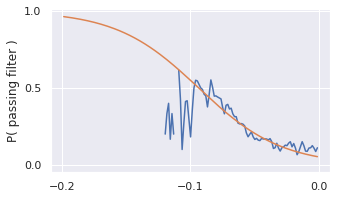

contact_molecular_surface from 10.183 to 511.179


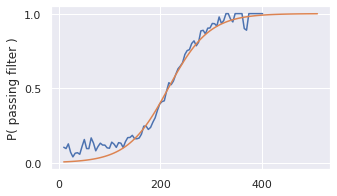

ddg_over_cms_pred
contact_molecular_surface_pred

-predictor_filters ddg_over_cms,contact_molecular_surface
-equation="- 1 / ( 1 + EXP( -( ddg_over_cms - -0.09364 ) * -30.99618 ) ) * 1 / ( 1 + EXP( -( contact_molecular_surface - 216.12229 ) * 0.02485 ) ) "


In [11]:
# This code is a little out-dated, but it still works
# We have the test_indices set to 0.1% because the curve fitting removes memorization

train_df = pilot_df.copy(True)
all_indices = list(range(len(train_df)))
test_indices = []

# This sets up maximum likihood method
not_used, prob_arrays = train_and_predict_mle(train_df, all_indices, test_indices, terms_and_cuts, "predict", predictor_df, True)

print("")
print('-predictor_filters ' + ",".join( terms_and_cuts[x][2][:-5] for x in list(terms_and_cuts)))
print('-equation="-' + "*".join(eqs) + '"')
with open(f'{mpnn1_path}/filter_eq.txt','w') as f_out:
    f_out.write('"-' + "*".join(eqs) + '"\n')



ddg_over_cms_pred
contact_molecular_surface_pred


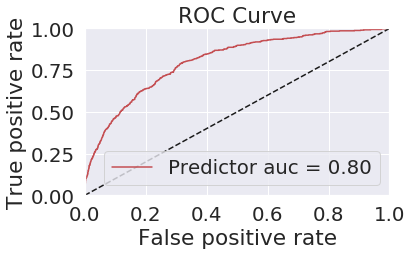

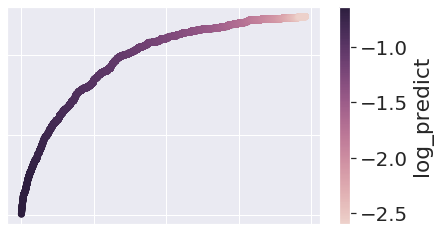

ddg_over_cms_pred
contact_molecular_surface_pred


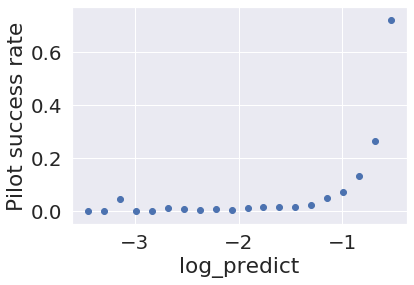

In [12]:
# Apply the mle method to the training set to get a feel for how well it worked
apply_prob_arrays(pilot_df, prob_arrays, "predict")
pilot_df['log_predict'] = np.log10(pilot_df['predict'])
plot_df = pilot_df
fpr,tpr,thresholds = roc_curve(plot_df["orderable"], plot_df["predict"])

fig, ax = plt.subplots(figsize=(6,4))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'r', label = "Predictor auc = %.2f"%(auc(fpr, tpr)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.tight_layout()
plt.show()

# Make a cool graph to get a feel for where different predict values lie
df_c=pilot_df.sort_values("predict", ascending=False)
df_c['total_orderable'] = df_c['orderable'].cumsum()
df_c['log_predict'] = np.log10(df_c['predict'])


cmap = sns.cubehelix_palette(as_cmap=True)

lowb = np.percentile(df_c['log_predict'], 2)
upb = np.percentile(df_c['log_predict'], 98)
f, ax = plt.subplots(figsize=(7, 4))
points = ax.scatter(range(len(df_c)), df_c['total_orderable'], c=df_c['log_predict'], vmin=lowb,vmax=upb, cmap=cmap)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
cb = f.colorbar(points)
cb.set_label("log_predict")

plt.show()

apply_prob_arrays(predictor_df, prob_arrays, "predict")
predictor_df['log_predict'] = np.log10(predictor_df['predict'])
minimum = predictor_df['log_predict'].min()
maximum = predictor_df['log_predict'].max()
steps = 20
step = (maximum - minimum)/steps
probability_mapping_x = np.arange(minimum, maximum, step)
probability_mapping_y = []

last_prob = None
for step_prob in probability_mapping_x:
    upper = step_prob + step
    total = pilot_df[(pilot_df['log_predict'] > step_prob) & (pilot_df['log_predict'] < upper)]
    orderable = total['orderable'].sum()
    if ( len(total) < 10 ):
        prob = last_prob
    else:
        prob = orderable / len(total)
    probability_mapping_y.append(prob)
    last_prob = prob
# fill in the beginning
last_prob = probability_mapping_y[-1]
for i in range(len(probability_mapping_y)):
    i = len(probability_mapping_y) - i - 1
    if ( probability_mapping_y[i] is None ):
        probability_mapping_y[i] = last_prob
    last_prob = probability_mapping_y[i]

probability_mapping_y = np.array(probability_mapping_y)
    
plt.xlabel("log_predict")
plt.ylabel("Pilot success rate")
plt.scatter(probability_mapping_x, probability_mapping_y)
plt.show()

ddg_over_cms_pred
contact_molecular_surface_pred


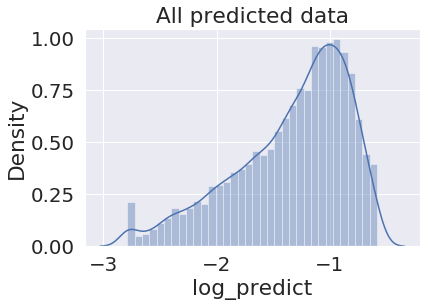

In [13]:
# Apply the mle to the predictor data and see how the values look

apply_prob_arrays(predictor_df, prob_arrays, "predict")
predictor_df['log_predict'] = np.log10(predictor_df['predict'])
bounds = (np.percentile(predictor_df['log_predict'], 1), np.percentile(predictor_df['log_predict'], 99))
sns.distplot(predictor_df['log_predict'].clip(bounds[0], bounds[1]))
plt.title("All predicted data")
plt.show()

In [14]:
fraction_to_design = 0.05
topXp = int(len(predictor_df)*fraction_to_design)
MLE_cut = list(sorted(-predictor_df['log_predict']))[topXp]
print(f'To predict for the top {fraction_to_design*100}% use an MLE cutoff > {-MLE_cut}')
print(f'In your data set this corresponds to {topXp} successes out of {len(predictor_df)}')

with open(f'{mpnn1_path}/filter_cut.txt','w') as f_out:
    f_out.write(str(-MLE_cut) + '\n')

To predict for the top 5.0% use an MLE cutoff > -0.70592685062129
In your data set this corresponds to 487 successes out of 9753


## MPNN Stage 1

Follow the steps below to run MPNN on the entire RIFdock outputs. The commands below use the prefilter calibration files generated in "MPNN Stage 1 Prefilter Calibration" to pre-empt full Rosetta relax on designs that do not pass the filter. 

In [3]:
### Get silent files
input_silents = glob.glob(f'{rifdock_path}/{ID}_rifdock_output/*.silent')
print(len(input_silents))

25386


In [4]:
# This cell launches jobs to predict MPNN sequences from rifdock outputs. 
# By default, 1 sequence will be generated per dock. 
# Predictor is run on all outputs. The best 5% (calibration above) will be relaxed.

prefilter_eq_file = f'{mpnn1_path}/filter_eq.txt'
prefilter_mle_cut_file = f'{mpnn1_path}/filter_cut.txt'

cmds = f'{mpnn1_path}/cmds_design_production'
os.makedirs(f'{mpnn1_path}/production/',exist_ok=True)
with open(cmds,'w') as f_out:
    n_commands=0
    for silent in input_silents:   
        silent_name = silent.split('/')[-1].replace(".silent","")
        output_dir = f'{mpnn1_path}/production/{silent_name}/'
        if os.path.isfile(output_dir + 'check.point'):
            with open(output_dir + 'check.point', 'r') as f:
                lines = f.readlines()
                if len(lines) > 900:
                    continue
        os.makedirs(output_dir, exist_ok=True)
        # Build cmd
        cmd = f'cd {output_dir}; \
                {ligandmpnn_apptainer} {ligandmpnn_script} -silent {silent} \
                                -seq_per_struct 1 \
                                -temperature 0.1 \
                                -freeze_hbond_resis 0 \
                                -bb_phos_cutoff 1 \
                                -hbond_energy_cut -0.5 \
                                -prefilter_eq_file {prefilter_eq_file} \
                                -prefilter_mle_cut_file {prefilter_mle_cut_file} \
                                -checkpoint_path {checkpoint_path} \
                                -run_predictor 1 \
                                -run_relax 1\n'
        f_out.write(cmd)
        n_commands += 1
        
env = 'source activate /home/nrbennet/miniconda3/envs/ampere'
if os.path.exists('logs'): shutil.rmtree('logs')
jupyter_utils.make_submit_file(cmds=cmds, env=env, submitfile=cmds+'.sh', group_size=round(n_commands/1000), timeout='12:00:00', queue='cpu-bf', cpus=1, mem='6G')
p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for clustering in {cmds}')

Prepared and submitted 17286 jobs for clustering in /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_1/mpnn1_CGCACCGACTCACG_SEP2022//cmds_design_production
Submitted batch job 72933


In [4]:
# Collect results from mpnn designs
combined_csv = 'combined.csv'
combined_silent = 'combined.silent'
useful_utils.collect_results(mpnn1_path,'production/*/',combined_csv,combined_silent)

25092 csvs were saved.
5229777 MPNN predictions were made, with 4.31% (225234) passing prefilters.
225234 relaxed models were produced. 4914 files had unexpected column length. 
25380 silent files were produced.


225221 designs passing xml prefilters

filter hard_cut low_soft_cut_limit
----------------------------------
base_score 10 -12.0
phosphate_score 0 -2
bidentate_score 1 -1
max_rboltz_RKQE 0.15 -1.85
avg_top_two_rboltz 0.1 -1.9
n_backbone_phosphate_contacts 0 -2
ddg -15 -0.01
contact_molecular_surface 225 0.108
net_charge_over_sasa -10 -2.272
ddg_over_cms -0.06 -0.001
mpnn_score 2 1.261

Hard cuts used to select orderable and setup the fuzzy cutoffs
--------------------------------------------------------------
                    base_score:  10.00
               phosphate_score:   0.00
               bidentate_score:   1.00
               max_rboltz_RKQE:   0.15
            avg_top_two_rboltz:   0.10
 n_backbone_phosphate_contacts:   0.00
                           ddg: -15.00
     contact_molecular_surface: 225.00
          net_charge_over_sasa: -10.00
                  ddg_over_cms:  -0.06
                    mpnn_score:   2.00

number of designs passing hard cuts
                   

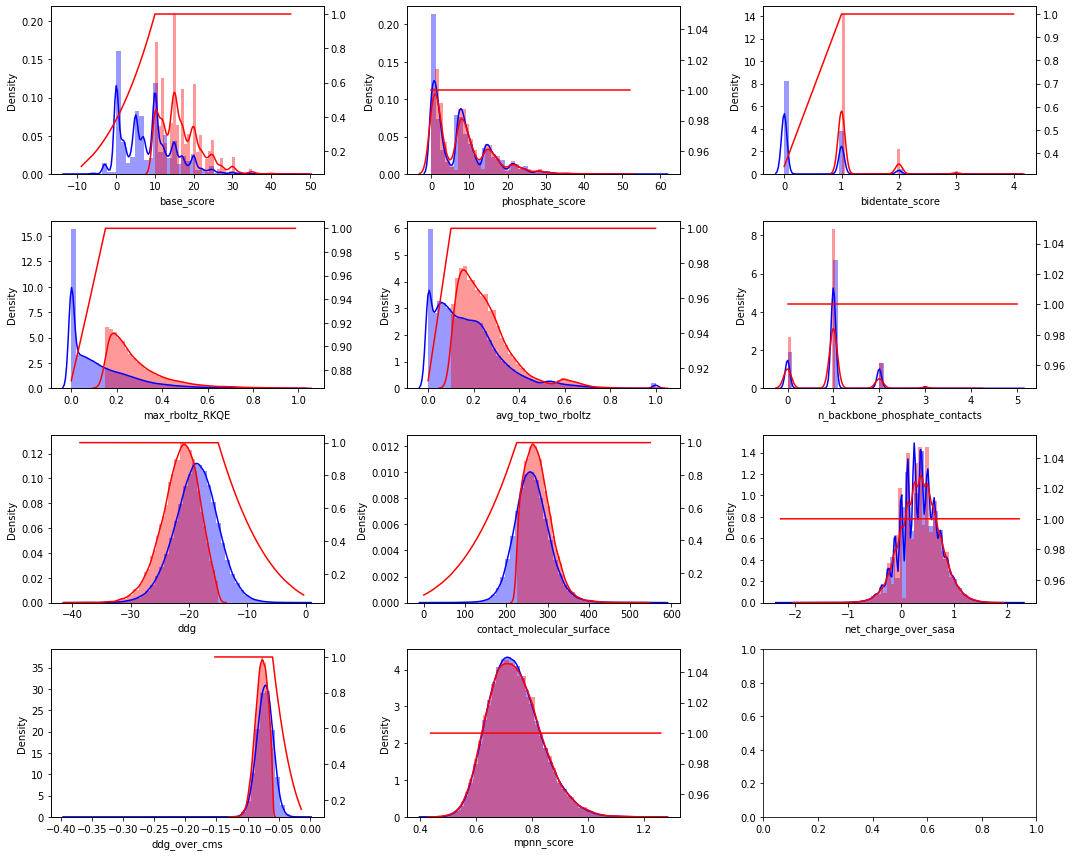


Order proposal: 17138 


In [5]:
# This cell filters the resulting outputs. You may play with filters to get a desired number of filtered outputs that look reasonable to you.
# You may change fraction not passing to allow some number of designs that are below the filter thresholds. 
# This is useful for testing if filters are helping in experiments.
# Use seqid_cut to cluster by sequence identify. seqid_cut of 1 will not cluster by sequence. 

fraction_not_passing = 0
seqid_cut = 1

df = pd.read_csv(f'{mpnn1_path}/combined.csv')
df = df[df['ddg'] < 0]
df = df[df['contact_molecular_surface'] > 0]

threshold_dict = {'base_score':[10,'>='],'phosphate_score':[0, '>='],'bidentate_score':[1, '>='],
                  'max_rboltz_RKQE':[0.15, '>='],'avg_top_two_rboltz':[0.1, '>='],'n_backbone_phosphate_contacts':[0,'>='],
                  'ddg':[-15,'<='],'contact_molecular_surface':[225,'>='],'net_charge_over_sasa':[-10,'>='],
                  'ddg_over_cms':[-0.06,'<='],'mpnn_score':[2,'<=']
                    }

df_filtered = useful_utils.filter_designs(mpnn1_path,df,threshold_dict,fraction_not_passing,seqid_cut)

In [6]:
SILENT_FILE = f'{mpnn1_path}/combined.silent'

### Save passing designs into a filtered silent.
selected_designs = []
for j in range(len(df_filtered)):
    selected_designs.append(str(df_filtered['tag'].iloc[j]))
print(len(selected_designs))

with open(f'{mpnn1_path}/filtered_designs.list', 'w') as f:
    for line in selected_designs:
        f.write(line + '\n')
        
print('Run this in the terminal to get your filtered silent file:\n')
print(f"cat filtered_designs.list | silentslice {SILENT_FILE} > combined_filtered.silent")

df_filtered.to_csv(f'{mpnn1_path}/combined_filtered.csv', index=False, header=True)

17138
Run this in the terminal to get your filtered silent file:

cat filtered_designs.list | silentslice /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_1/mpnn1_CGCACCGACTCACG_SEP2022//combined.silent > combined_filtered.silent


In [18]:
print("""mkdir filtered_pdbs
cd filtered_pdbs
silentextract ../combined_filtered.silent""")

mkdir filtered_pdbs
cd filtered_pdbs
silentextract ../combined_filtered.silent


In [6]:
# Save your final pwm filtered results


SILENT_FILE = f'{mpnn1_path}/combined_filtered.silent'

# These are your designs!!!
selected_designs = []
for j in range(len(df_pwm_filtered)):
    selected_designs.append(str(df_pwm_filtered['tag'].iloc[j]))
print(len(selected_designs))


with open(f'{mpnn1_path}/pwm_filtered_designs.list', 'w') as f:
    for line in selected_designs:
        f.write(line + '\n')
        
print('Run this in the terminal to get your filtered silent file:\n')
print(f"""
cat pwm_filtered_designs.list | silentslice {SILENT_FILE} > combined_filtered_pwm.silent""")

df_pwm_filtered.to_csv(f'{mpnn1_path}/combined_filtered_pwm.csv', index=False, header=True)

2238
Run this in the terminal to get your filtered silent file:


cat pwm_filtered_designs.list | silentslice /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_1/mpnn1_CGCACCGACTCACG_SEP2022//combined_filtered.silent > combined_filtered_pwm.silent


## Inpainting: Scaffold Loop diversification 

This section is an optional section diversify designs with loop inpainting. This step could easily be replaced with RFdiffusion or partial RFdiffusion for loop inpainting, which is a more up to date technique. To perform design diversification by inpainting you will need to intall Inpainting from https://github.com/RosettaCommons/RFDesign. 

In [4]:
# extract pdbs from pwm filtered stage 2 designs
pwm_filtered_silent = f'{mpnn1_path}/combined_filtered_pwm.silent'
print(f"""
cd {inpainting1_path}
mkdir complex_pdbs
cd complex_pdbs
silentextract {pwm_filtered_silent}""")


cd /net/scratch/cjg263/de_novo_dna/results/inpainting/inpainting1_CGCACCGACTCACG_SEP2022/
mkdir complex_pdbs
cd complex_pdbs
silentextract /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_1/mpnn1_CGCACCGACTCACG_SEP2022//combined_filtered_pwm.silent


In [4]:
pdbs = glob.glob(f'{inpainting1_path}/complex_pdbs/*pdb')
print(len(pdbs))

2238


In [ ]:
init()
cmds = f'{inpainting1_path}/cmds_inpainting'

os.makedirs(f'{inpainting1_path}/input_pdbs',exist_ok=True)
os.makedirs(f'{inpainting1_path}/output_pdbs',exist_ok=True)

for pdb in pdbs:
    pose = pose_from_pdb(pdb)

    bb_phos_resis = useful_utils.get_bb_phos_contacts(pose)
    hbond_resis = useful_utils.count_hbonds_protein_dna(pose)
    fix_resis = bb_phos_resis + hbond_resis

    fix_resis = [str(j) for j in fix_resis]
    const_pos = ",".join(fix_resis)

    input_pdb = inpainting1_path + 'input_pdbs/' + pdb.split('/')[-1]
    useful_utils.write_new_pdb(pdb,input_pdb)
    
    with open(input_pdb.replace('.pdb','.cst'),'w') as f_out:
        f_out.write(const_pos)
        

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2021.38+release.4d5a9693c031951766d575fca9286ed34f560779 2021-09-22T20:45:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release r297 2021.38+release.4d5a969 4d5a9693c031951766d575fca9286ed34f560779 http://www.pyrosetta.org 2021-09-22T20:45:44
core.init: {0} command: PyRosetta -ex1 -ex2aro -database /software/conda/envs/pyrosetta/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=-300911088 seed_offset=0 real_seed=-300911088 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:init: Normal mode, seed=-300911088 RG_type=mt19

In [3]:
with open(f'{inpainting1_path}/gen_contigs.sh','w') as f_out:
    f_out.write(f"""
#!/bin/bash 


folder='{inpainting1_path}/input_pdbs/'

# spits out os.path.join(folder, 'dssp_all.csv')
/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/get_folder_dssp.py -folder $folder 

dssp_path=$folder'dssp_all.csv'


echo $dssp_path 

script='/projects/protein-DNA-binders/scripts/auto_contigs.py'
# apologies for the terrible variable names 
N=2
K=5
L=4
num_term=5
M=5

source  activate mlfold 

python $script --ss_csv $dssp_path -out ./ -K $K -N $N -l_flank $L -num_term $num_term -max_inpaint_change $M
""")

In [ ]:
! bash f'{inpainting1_path}/gen_contigs.sh'

In [4]:
sampling_depth = 20
cmds = f'{inpainting1_path}/cmds_inpainting'
with open(cmds,'w') as f_out:
    with open(f'{inpainting1_path}/contigs_out.tsv','r') as f_in:
        lines = f_in.readlines()[1:]
        for line in lines:
            pdb,contigs,inpaint_seq = line.rstrip().split('\t')
            outpdb = pdb.replace('input_pdbs','output_pdbs').replace('.pdb','')
            cmd = f'python /home/cjg263/software/proteininpainting_autoregressive/inpaint.py \
                    --pdb {pdb} \
                    --contigs {contigs} \
                    --inpaint_seq {inpaint_seq} \
                    --out {outpdb} \
                    --num_designs {sampling_depth}'
            f_out.write(cmd+'\n')

if os.path.exists('logs'): shutil.rmtree('logs')
env = 'source activate /home/dimaio/.conda/envs/SE3nv'

jupyter_utils.make_submit_file(cmds=cmds, env=env, submitfile=cmds+'.sh', timeout='15:00:00', group_size=50, queue='gpu', gres='gpu:a4000:1', cpus=2, mem='16G')

p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for clustering in {cmds}')

Prepared and submitted 2238 jobs for clustering in /net/scratch/cjg263/de_novo_dna/results/inpainting/inpainting2_CGCACCGACTCACG_SEP2022//cmds_inpainting
Submitted batch job 799274


In [4]:
pdbs = glob.glob(f'{inpainting1_path}/complex_pdbs/*pdb')
print(len(pdbs))

output_pdbs = glob.glob(f'{inpainting1_path}/output_pdbs/*pdb')
print(len(output_pdbs))

print(f'Expected {20*len(pdbs)} pdbs.')

2238
44760
Expected 44760 pdbs.


In [3]:
pdbs = glob.glob(f'{inpainting1_path}/complex_pdbs/*pdb')
inpainted_pdbs = f'{inpainting1_path}/output_pdbs/'

align_script = '/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/inpainting_align.py'

cmds = f'{inpainting1_path}/cmds_align'
with open(cmds, 'w') as f_out:
    for pdb in pdbs:
        pdb_name = pdb.split('/')[-1].replace('.pdb','')
        output_dir = f'{inpainting1_path}/align_inpaints/{pdb_name}/'
        os.makedirs(output_dir,exist_ok=True)
        with open(output_dir + 'pdbs.list', 'w') as f:
            f.write(pdb)
        cmd = f'cd {output_dir}; \
                {ligandmpnn_apptainer} {align_script} {inpainting1_path} {inpainted_pdbs}\n'
        f_out.write(cmd)

if os.path.exists('logs'): shutil.rmtree('logs')
jupyter_utils.make_submit_file(cmds=cmds, submitfile=cmds+'.sh', group_size=3, queue='cpu', timeout='1:00:00', cpus=1, mem='3G')
#p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for alignment in {cmds}')

Prepared and submitted 2238 jobs for alignment in /net/scratch/cjg263/de_novo_dna/results/inpainting/inpainting2_CGCACCGACTCACG_SEP2022//cmds_align


In [7]:
## get secondary structure of all inpaints for the subsequent trimming step
pdb_folders = glob.glob(f'{inpainting1_path}/align_inpaints/*/')

cmds = f'{inpainting1_path}/cmds_dssp'
with open(cmds, 'w') as f_out:
    for pdb_folder in pdb_folders:
        cmd = f'/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/get_folder_dssp.py -folder {pdb_folder}\n'
        f_out.write(cmd)

if os.path.exists('logs'): shutil.rmtree('logs')
jupyter_utils.make_submit_file(cmds=cmds, submitfile=cmds+'.sh', group_size=20, queue='cpu', timeout='1:00:00', cpus=1, mem='3G')
#p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for alignment in {cmds}')

Prepared and submitted 2238 jobs for alignment in /net/scratch/cjg263/de_novo_dna/results/inpainting/inpainting2_CGCACCGACTCACG_SEP2022//cmds_dssp


In [20]:
## Trim long sequences
## This cell finds all pdbs with protein length > max_len, and trims around the HTH motif
## The saved pdbs will be renumbered starting at 1
max_len = 65
dna_len = 28
trim_increment = 5

os.makedirs(outdir,exist_ok=True)

total_trims = 0
dssp_files = glob.glob(f'{inpainting1_path}/align_inpaints/*/dssp_all.csv')
for dssp_file in dssp_files:    
    complex_pdb = dssp_file.split('/')[-2]
    with open(dssp_file,'r') as dssp_f:
        dssp_lines = dssp_f.readlines()[2:]
        
    for dssp_line in dssp_lines:
        pdb = dssp_line.split(',')[0]
        ss = dssp_line.split(',')[1]
        
        ss_prot = ss[:-dna_len]
        if len(ss_prot) <= max_len: continue
        
        resis, fix_resis, RH_resis, TURN_resis, AH_resis = useful_utils.get_annotation(pdb)
        len_prot = len(resis)
        
        # fix_resis are the AH-TURN-RH resis, we want to add an extra SS element to these on either side of the core HTH motif.
        # add n-terminal sec struct
        if 'H' in ss_prot[:min(fix_resis)] or 'L' in ss_prot[:min(fix_resis)]:
            adjacent_loop = True
            for j in range(min(fix_resis)-1,0,-1):
                if len(fix_resis) >= max_len: break
                ss = ss_prot[j]
                ss_prev = ss_prot[j+1]
                ss_prev2 = ss_prot[j+2]
                if ss == 'L' and adjacent_loop: 
                    fix_resis = [j] + fix_resis
                elif ss != 'L' and ss_prev != 'L' and ss_prev2 == 'L':
                    fix_resis = [j] + fix_resis
                    adjacent_loop = False
                elif ss == 'L' and not adjacent_loop:
                    break
                else:
                    fix_resis = [j] + fix_resis
            
        # add c-terminal sec struct
        if 'H' in ss_prot[max(fix_resis)-1:] or 'L' in ss_prot[max(fix_resis)-1:]:
            adjacent_loop = True
            
            for j in range(max(fix_resis)+1,len_prot+1):
                if j > len(ss_prot) : break
                if len(fix_resis) >= max_len: break
                
                ss = ss_prot[j]
                ss_prev = ss_prot[j-1]
                ss_prev2 = ss_prot[j-2]
                if ss == 'L' and adjacent_loop: 
                    fix_resis = fix_resis + [j]
                elif ss != 'L' and ss_prev != 'L' and ss_prev2 == 'L':
                    fix_resis = fix_resis + [j]
                    adjacent_loop = False
                elif ss == 'L' and not adjacent_loop:
                    break
                else:
                    fix_resis = fix_resis + [j]

        n = 0 
        # generate trimmed pdbs by looping through at defined increments and ensuring all fixed resis and included in the trimmed structure
        for j in range(1,len(ss_prot)-max_len+1,trim_increment):
            min_resi = j
            max_resi = j+max_len -1

            if not min(fix_resis) >= min_resi or not max(fix_resis) <= max_resi: continue
            keep_resis = [resi for resi in range(min_resi,max_resi+1)] + [dna_resi for dna_resi in range(len_prot+1, len_prot+dna_len+1)]

            pdbout = pdb.replace('.pdb',f'_trim{n}.pdb')
            with open(pdb,'r') as f_in:
                lines = f_in.readlines()
                with open(pdbout,'w') as f_out:
                    for line in lines:
                        if line.startswith('ATOM') and int(line[23:26].strip()) in keep_resis:
                            old_resi = int(line[23:26].strip())
                            if old_resi <= max_resi:
                                new_resi = old_resi - (min_resi - 1)
                            else:
                                new_resi = old_resi - (min_resi - 1) - (len_prot - max_resi)
                            new_line = line[:23] + format(new_resi, ' 3d') + ' ' + line[27:]
                            f_out.write(new_line)
                        if line.startswith('REMARK PDBinfo-LABEL:') and int(line[23:26].strip()) in keep_resis:
                            old_resi = int(line[23:26].strip()) 
                            if old_resi <= max_resi:
                                new_resi = old_resi - (min_resi - 1)
                            else:
                                new_resi = old_resi - (min_resi - 1) - (len_prot - max_resi)
                            new_line = line[:23] + format(new_resi, ' 3d') + ' ' + line[27:]
                            f_out.write(new_line)
            n += 1
            total_trims += 1
print(total_trims)

31128


In [31]:
aligned_pdbs = glob.glob(f'{inpainting1_path}/align_inpaints/*/*pdb')
print(len(aligned_pdbs))

78127


## MPNN Stage 2: MPNN design of inpainted scaffolds

Now that you can run loop inpainting, you will redesign the proten sequences with LigandMPNN similarly to MPNN Stage 1. 

In [7]:
pdbs = glob.glob(f'{inpainting1_path}/complex_pdbs/*pdb')
print(len(pdbs))

2238


In [9]:
# This cell launches jobs to predict MPNN sequences from inpainting1 outputs.
prefilter_eq_file = f'{mpnn1_path}/filter_eq.txt'
prefilter_mle_cut_file = f'{mpnn1_path}/filter_cut.txt'

cmds = f'{mpnn2_path}/cmds_design_production'
os.makedirs(f'{mpnn2_path}/production/',exist_ok=True)
with open(cmds,'w') as f_out:
    n_commands=0
    for pdb in pdbs:   
        pdb_name = pdb.split('/')[-1].replace('.pdb','')
        pdb_folder = f'{inpainting1_path}/align_inpaints/{pdb_name}/'
        output_dir = f'{mpnn2_path}/production/{pdb_name}/'
        if os.path.isfile(output_dir + 'check.point'):
            with open(output_dir + 'check.point', 'r') as f:
                lines = f.readlines()
                if len(lines) > 900:
                    continue
        os.makedirs(output_dir, exist_ok=True)
        #Build cmd
        cmd = f'cd {output_dir}; \
                {ligandmpnn_apptainer} {ligandmpnn_script} -pdb_folder {pdb_folder} \
                                -seq_per_struct 4 \
                                -temperature 0.2 \
                                -freeze_hbond_resis 0 \
                                -bb_phos_cutoff 0 \
                                -hbond_energy_cut -0.5 \
                                -prefilter_eq_file {prefilter_eq_file} \
                                -prefilter_mle_cut_file {prefilter_mle_cut_file} \
                                -checkpoint_path {checkpoint_path} \
                                -run_predictor 1 \
                                -run_relax 1\n'
        f_out.write(cmd)
        n_commands += 1
        
if os.path.exists('logs'): shutil.rmtree('logs')
jupyter_utils.make_submit_file(cmds=cmds, env=env, submitfile=cmds+'.sh', group_size=3, timeout='12:00:00', queue='cpu-bf', cpus=1, mem='6G')
#p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for clustering in {cmds}')

Prepared and submitted 2238 jobs for clustering in /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_2/mpnn2_CGCACCGACTCACG_SEP2022//cmds_design_production


In [81]:
# Collect results
combined_csv = 'combined_stage_2.csv'
combined_silent = 'combined_stage_2.silent'
useful_utils.collect_results(mpnn2_path,'production/*/',combined_csv,combined_silent)

2177 csvs were saved.
247446 MPNN predictions were made, with 21.99% (54425) passing prefilters.
54425 relaxed models were produced. 498 files had unexpected column length. 
1679 silent files were produced.


In [82]:
#This cell makes a combined.silent with both MPNN stage 1 and stage 2 designs. 
mpnn1_silents = glob.glob(f'{mpnn1_path}/combined_filtered_pwm.silent')
mpnn2_silents = glob.glob(f'{mpnn2_path}/combined_stage_2.silent')

silent_out = f'{mpnn2_path}/stage_1_2_combined.silent'
with open(silent_out, 'w') as f_out:
    for silent in mpnn1_silents:
        with open(silent,'r') as f_in:
            lines = f_in.readlines()
            for line in lines:
                f_out.write(line)
    for silent in mpnn2_silents:
        with open(silent,'r') as f_in:
            lines = f_in.readlines()
            for line in lines:
                f_out.write(line)

In [83]:
# Collecting the resulting data into a csv file. 
df_stage_1 = pd.read_csv(f'{mpnn1_path}/combined_filtered_pwm.csv')
df_stage_1['stage'] = 1
df_stage_1 = df_stage_1.drop(columns=['cluster'])
print(len(df_stage_1))

df_stage_2 = pd.read_csv(f'{mpnn2_path}/combined_stage_2.csv')
df_stage_2['stage'] = 2
df_stage_2 = df_stage_2.drop_duplicates(subset=["sequence"])
df_stage_2.to_csv(f'{mpnn2_path}/combined_stage_2.csv')
print(len(df_stage_2))

df_all = pd.concat([df_stage_1,df_stage_2])
for column in df_all.columns:
    if 'Unnamed' in column:
        df_all = df_all.drop(columns=[column])
        
seq_lens = []
for j, row in df_all.iterrows():
    seq_len = len(row['sequence'])
    seq_lens.append(seq_len)
    
df_all['seq_len'] = seq_lens
df_all.to_csv(f'{mpnn2_path}/stage_1_2_combined.csv')

2238
54425


56630 designs passing xml prefilters

filter hard_cut low_soft_cut_limit
----------------------------------
base_score 10 -9.0
phosphate_score 0 -2
bidentate_score 0 -2
max_rboltz_RKQE 0.15 -1.85
avg_top_two_rboltz 0.1 -1.9
n_backbone_phosphate_contacts 0 -2
ddg -15 -0.128
contact_molecular_surface 225 3.362
net_charge_over_sasa -10 -2.192
ddg_over_cms -0.06 -0.0
mpnn_score 2 1.486
seq_len 65 118.0

Hard cuts used to select orderable and setup the fuzzy cutoffs
--------------------------------------------------------------
                    base_score:  10.00
               phosphate_score:   0.00
               bidentate_score:   0.00
               max_rboltz_RKQE:   0.15
            avg_top_two_rboltz:   0.10
 n_backbone_phosphate_contacts:   0.00
                           ddg: -15.00
     contact_molecular_surface: 225.00
          net_charge_over_sasa: -10.00
                  ddg_over_cms:  -0.06
                    mpnn_score:   2.00
                       seq_len:  65.00

nu

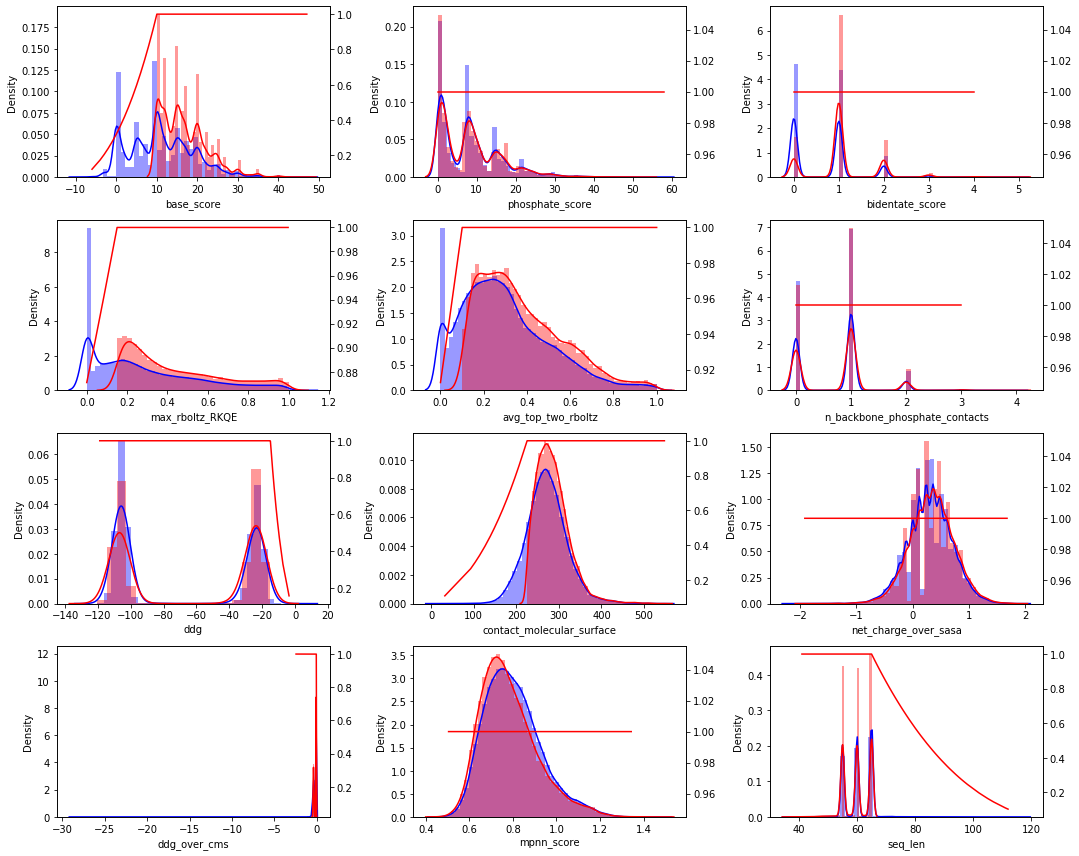


Order proposal: 20465 


In [36]:
# This cell filters the resulting outputs. You may play with filters to get a desired number of filtered outputs that look reasonable to you.
# You may change fraction not passing to allow some number of designs that are below the filter thresholds. 
# This is useful for testing if filters are helping in experiments.
# Use seqid_cut to cluster by sequence identify. seqid_cut of 1 will not cluster by sequence. 

fraction_not_passing = 0
seqid_cut = 1

df = pd.read_csv(f'{mpnn2_path}/stage_1_2_combined.csv')
df = df[df['ddg'] < 0]
df = df[df['contact_molecular_surface'] > 0]

threshold_dict = {'base_score':[10,'>='],'phosphate_score':[0, '>='],'bidentate_score':[0, '>='],
                  'max_rboltz_RKQE':[0.15, '>='],'avg_top_two_rboltz':[0.1, '>='],'n_backbone_phosphate_contacts':[0,'>='],
                  'ddg':[-15,'<='],'contact_molecular_surface':[225,'>='],'net_charge_over_sasa':[-10,'>='],
                  'ddg_over_cms':[-0.06,'<='],'mpnn_score':[2,'<='],'seq_len':[65,'<=']
                    }

df_filtered = useful_utils.filter_designs(mpnn2_path,df,threshold_dict,fraction_not_passing,seqid_cut)

In [ ]:
# Saved the filtered diversified models into a new silent file.

SILENT_FILE = f'{mpnn2_path}/stage_1_2_combined.silent'

### Save passing designs. Stop here for continuing to Motif Graft
selected_designs = []
for j in range(len(df_filtered)):
    selected_designs.append(str(df_filtered['tag'].iloc[j]))
print(len(selected_designs))

with open(f'{mpnn2_path}/filtered_designs.list', 'w') as f:
    for line in selected_designs:
        f.write(line + '\n')
        
print('Run this in the terminal to get your filtered silent file:\n')
print(f"cat filtered_designs.list | silentslice {SILENT_FILE} > stage_1_2_filtered.silent")

df_filtered.to_csv(f'{mpnn2_path}/stage_1_2_filtered.csv', index=False, header=True)

In [ ]:
# Split the silent from the last step for launching MPNN diversification jobs.
silent_file = f'{mpnn2_path}/stage_1_2_filtered.silent'
print(f"""
cd {mpnn2_path}
qlogin --mem=10g
mkdir silent_splits
cd silent_splits
silentsplitshuf {silent_file} 20
cd ..
""")

## MPNN Stage 3: MPNN of Stage 2 FR models

This is an optional step. Cycles of Ligandmpnn design + Rosetta FastRelax have been shown to improve pass rates through AlphaFold2. Follow the steps below to do this. 

In [23]:
input_silents = glob.glob(f'{mpnn2_path}/silent_splits/*.silent')
print(len(input_silents))

2238


In [30]:
# This cell launches jobs to predict MPNN sequences from rifdock outputs. 
# By default, 1 sequence will be generated per dock. 
# Predictor is run on all outputs. The best 5% (calibration above) will be relaxed.

prefilter_eq_file = f'{mpnn1_path}/filter_eq.txt'
prefilter_mle_cut_file = f'{mpnn1_path}/filter_cut.txt'

cmds = f'{mpnn3_path}/cmds_design_production'
os.makedirs(f'{mpnn3_path}/production/',exist_ok=True)
with open(cmds,'w') as f_out:
    n_commands=0
    for silent in input_silents:   
        silent_name = silent.split('/')[-1].replace(".silent","")
        output_dir = f'{mpnn3_path}/production/{silent_name}/'
        
        # Check if checkpoint file is complete. This is useful for requeuing jobs. 
        if os.path.isfile(output_dir + 'check.point'):
            with open(output_dir + 'check.point', 'r') as f:
                lines = f.readlines()
                if len(lines) == 20:
                    continue
        os.makedirs(output_dir, exist_ok=True)
        # Build cmd
        cmd = f'cd {output_dir}; \
                {ligandmpnn_apptainer} {ligandmpnn_script} -silent {silent} \
                                -seq_per_struct 10 \
                                -temperature 0.1 \
                                -freeze_hbond_resis 0 \
                                -bb_phos_cutoff 0 \
                                -hbond_energy_cut -0.5 \
                                -prefilter_eq_file {prefilter_eq_file} \
                                -prefilter_mle_cut_file {prefilter_mle_cut_file} \
                                -checkpoint_path {checkpoint_path} \
                                -run_predictor 1 \
                                -run_relax 0\n'
        f_out.write(cmd)
        n_commands += 1
        
if os.path.exists('logs'): shutil.rmtree('logs')
jupyter_utils.make_submit_file(cmds=cmds, env=env, submitfile=cmds+'.sh', group_size=round(n_commands/1000), timeout='12:00:00', queue='cpu-bf', cpus=1, mem='6G')
p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for clustering in {cmds}')

Prepared and submitted 2238 jobs for clustering in /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_3/mpnn3_CGCACCGACTCACG_SEP2022//cmds_design_production


In [3]:
# Collect results
combined_csv = 'combined_stage_3.csv'
combined_silent = 'combined_stage_3.silent'
useful_utils.collect_results(mpnn3_path,'production/*/',combined_csv,combined_silent)

2115 csvs were saved.
316721 MPNN predictions were made, with 16.84% (53346) passing prefilters.
53346 relaxed models were produced. 572 files had unexpected column length. 
1557 silent files were produced.


In [4]:
#This cell makes a combined.silent with both MPNN stage 1 and stage 2 designs. 
mpnn2_silents = glob.glob(f'{mpnn2_path}/stage_1_2_filtered.silent')
mpnn3_silents = glob.glob(f'{mpnn3_path}/combined_stage_3.silent')

silent_out = f'{mpnn3_path}/stage_1_2_3_combined.silent'
with open(silent_out, 'w') as f_out:
    for silent in mpnn2_silents:
        with open(silent,'r') as f_in:
            lines = f_in.readlines()
            for line in lines:
                f_out.write(line)
    for silent in mpnn3_silents:
        with open(silent,'r') as f_in:
            lines = f_in.readlines()
            for line in lines:
                f_out.write(line)

In [5]:
# Collecting the resulting data into a csv file. 
df_stage_1_2 = pd.read_csv(f'{mpnn2_path}/stage_1_2_filtered.csv')
print(len(df_stage_1_2))

df_stage_3 = pd.read_csv(f'{mpnn3_path}/combined_stage_3.csv')
df_stage_3['stage'] = 3
df_stage_3.to_csv(f'{mpnn3_path}/combined_stage_3.csv')
print(len(df_stage_3))

df_all = pd.concat([df_stage_1_2,df_stage_3])
for column in df_all.columns:
    if 'Unnamed' in column:
        df_all = df_all.drop(columns=[column])
        
seq_lens = []
for j, row in df_all.iterrows():
    seq_len = len(row['sequence'])
    seq_lens.append(seq_len)
df_all['seq_len'] = seq_lens
    
df_all = df_all.drop_duplicates(subset=["sequence"])
df_all.to_csv(f'{mpnn3_path}/stage_1_2_3_combined.csv')

2238
54425
53346


## AF2 Superposition

In [12]:
silent_file = f'{mpnn3_path}/stage_1_2_3_combined.silent'
print(f"""
qlogin -c 2 --mem=16g --gres=gpu:rtx2080:1 -p gpu
cd {af2_path}
GRES="gpu:rtx2080:1"
source activate cjg-pyrosetta
/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/silentsketchextractch1 {silent_file} > in.silent
/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/interfaceaf2create -prefix predict_monomers -script /projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/monomerAF2predict.py -p gpu-bf -silent in.silent -args " -batch 1 -recycle 12" -gres $GRES -conda /mnt/home/nrbennet/miniconda3/envs/ampere -structs_per_job 1000
bash ./test_command.sh
""")


qlogin -c 2 --mem=16g --gres=gpu:rtx2080:1 -p gpu
cd /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022/
GRES="gpu:rtx2080:1"
source activate cjg-pyrosetta
/home/nrbennet/software/silent_tools/silentsketchextractch1 /net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_3/mpnn3_ACCGGGACG_JUL2022//stage_2_3_filtered.silent > in.silent
/home/nrbennet/software/nates_local_tools/interfaceaf2create -prefix predict_monomers -script /mnt/home/nrbennet/software/dl/af2/alphafold/batch/monomerAF2predict.py -silent in.silent -args " -batch 1 -recycle 12" -gres $GRES -conda /mnt/home/nrbennet/miniconda3/envs/ampere -structs_per_job 1000
bash ./test_command.sh



In [13]:
# If test_command.sh is working properly run this:
print(f"""
cd {af2_path}
bash run_submit.sh
""")


cd /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022/
bash run_submit.sh



In [14]:
# Collect silents when af2 predictions are complete
af2_silents = glob.glob(f'{af2_path}/predict_monomers_runs/*/out.silent')
print(len(af2_silents))
with open(f'{af2_path}/af2_predictions.silent','w') as f_out:
    for af2_silent in af2_silents:
        with open(af2_silent, 'r') as f_in:
            for line in f_in.readlines():
                f_out.write(line)


cat predict_monomers_runs/*/out.silent> af2_predictions.silent



In [15]:
# Use this cell to calculate rmsd to design. Continue to next step while this runs.
cmd = f'cd {af2_path}; \
        /home/cjg263/de_novo_dna/notebooks/scripts/scaffoldRMSD.py \
        -in:file:silent {af2_path}/af2_predictions.silent \
        -parents {af2_path}/in.silent \
        -exact_match; \n'
print(cmd)

cd /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022/;         /home/cjg263/de_novo_dna/notebooks/scripts/scaffoldRMSD.py         -in:file:silent /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022//af2_predictions.silent         -parents /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022//in.silent         -exact_match; 



In [16]:
# Launch jobs to superposition AF2 predicted monomers onto design complexes.

print(f"""
mkdir swap
cd swap

AF2_MONOMER_SILENT=../af2_predictions.silent
COMPLEX_SILENT={mpnn3_path}/stage_2_3_filtered.silent

af2_monomer_silent=$(readlink -f $AF2_MONOMER_SILENT)
complex_silent=$(readlink -f $COMPLEX_SILENT)

/projects/protein-DNA-binders/scripts/divpyjobs -prefix binder_swap -script /projects/protein-DNA-binders/scripts/swap_binder.py -p short -mem 5 -c 1 -structs_per_job 200 -silent $complex_silent -args " -af2_apo_binders $af2_monomer_silent -af2_binder_suffix _af2pred"
""")


mkdir swap
cd swap

AF2_MONOMER_SILENT=../af2_predictions.silent
COMPLEX_SILENT=/net/scratch/cjg263/de_novo_dna/results/mpnn_design_stage_3/mpnn3_ACCGGGACG_JUL2022//stage_2_3_filtered.silent

af2_monomer_silent=$(readlink -f $AF2_MONOMER_SILENT)
complex_silent=$(readlink -f $COMPLEX_SILENT)

/home/nrbennet/software/nates_local_tools/divpyjobs -prefix binder_swap -script /projects/protein-DNA-binders/scripts/swap_binder.py -p short -mem 5 -c 1 -structs_per_job 200 -silent $complex_silent -args " -af2_apo_binders $af2_monomer_silent -af2_binder_suffix _af2pred"



In [7]:
# Collect silents when superposition jobs are complete
af2_silents = glob.glob(f'{af2_path}/swap/binder_swap_runs/*/out.silent')
print(len(af2_silents))
with open(f'{af2_path}/superimpose.silent','w') as f_out:
    for af2_silent in af2_silents:
        with open(af2_silent, 'r') as f_in:
            for line in f_in.readlines():
                f_out.write(line)


cat swap/binder_swap_runs/*/out.silent > superimpose.silent


In [3]:
# Run relax on superpositioned models. This runs a fixed backbone relax. 
superimpose_silent='../superimpose.silent'
relax_xml = '/home/cjg263/de_novo_dna/notebooks/scripts/af2_superposition_fastrelaxinterface.xml' # <---this uses 47D flags. Change if necessary.

print(f'mkdir relax; cd relax; /projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/testcreatearrayjobs \
            -prefix fixed_bb_interface_relax \
            -xml {relax_xml} \
            -flags /projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/2b_design_mpnn/flags_and_weights/RM8B_flags \
            -silent {superimpose_silent} \
            -structs_per_job 15 \
            -mem 6 -p cpu \
            -rosetta /home/rpmchugh/software/Rosetta/main/source/bin/rosetta_scripts.default.linuxgccrelease \
            -hard_split \
            ')

mkdir relax; cd relax; /home/nrbennet/software/nates_local_tools/testcreatearrayjobs             -prefix fixed_bb_interface_relax             -xml /home/cjg263/de_novo_dna/notebooks/scripts/af2_superposition_fastrelaxinterface.xml             -flags /projects/protein-DNA-binders/flags_and_weights/flags_RM8B_fbb_relax.flags             -silent ../superimpose.silent             -structs_per_job 15             -mem 6 -p medium             -rosetta /home/rpmchugh/software/Rosetta/main/source/bin/rosetta_scripts.default.linuxgccrelease             -hard_split             


In [6]:
### Get silent files
input_silents = glob.glob(f'{af2_path}/relax/fixed_bb_interface_relax_runs/*/out.silent')
print(len(input_silents))

1021


In [7]:
# Compute scores for superpositioned relaxed models. 

flags_file = '/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/2b_design_mpnn/flags_and_weights/flags_RM8B'
weights_file='/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/2b_design_mpnn/flags_and_weights/RM8B_torsional.wts'

script = '/projects/protein-DNA-binders/dna_binder_manuscript/code_repo/dbp_design/software/compute_hbond_scores_rboltz_no_align.py'


def id_generator(size=12, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))

cmds = f'{af2_path}/cmds_compute_scores'
with open(cmds,'w') as f_out:
    n_commands=0
    for silent in input_silents:   
        silent_name = silent.split('/')[-2]

        # Build cmd
        rand_string = id_generator()
        outsilent = f'{af2_path}/compute_scores/{silent_name}/out.silent'  
        cmd = f'{pyros} {script} --silent_in {silent} \
                             --silent_out {outsilent} \
                             --weights {weights_file} \
                             --hbond_energy_cut -0.5 \
                             --flags_file {flags_file} '
        f_out.write(cmd+'\n')
        n_commands += 1

if os.path.exists('logs'): shutil.rmtree('logs')
jupyter_utils.make_submit_file(cmds=cmds, submitfile=cmds+'.sh', group_size=1, queue='short', cpus=1, mem='3G')
p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for clustering in {cmds}')

Prepared and submitted 1021 jobs for clustering in /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022//cmds_compute_scores
Submitted batch job 49173640


In [8]:
# collect superpositioned and relaxed silents.
silent_outputs = glob.glob(f'{af2_path}/compute_scores/*/out.silent')
print(len(silent_outputs))
with open(f'{af2_path}/combined.silent', 'w') as outfile:
    for silent in silent_outputs:
        with open(silent) as infile:
            for line in infile:
                outfile.write(line)

1021


In [9]:
# Collect plddt data
sc_fs = glob.glob(f'{af2_path}/predict_monomers_runs/*/out.sc')
df_plddt = pd.concat([pd.read_csv(sc_f,sep='\s+') for sc_f in sc_fs],sort=False)
tags = []
for j in range(len(df_plddt)):
    tag = re.sub('_af2pred$','_0001_',df_plddt['description'].iloc[j],)
    tags.append(tag)
df_plddt['out_tag'] = tags
df_plddt = df_plddt.drop(columns=['SCORE:','time','description'])
print(f'{len(df_plddt)} plddt values')

# Collect data for rmsd to design
with open(f'{af2_path}/pair_rmsd.sc','r') as f_in:
    with open(f'{af2_path}/pair_rmsd_clean.sc', 'w') as f_out:
        lines = f_in.readlines()
        f_out.write(lines[0])
        for line in lines[1:]:
            if 'all_rmsd' not in line:
                f_out.write(line)
df_rmsd = pd.read_csv(f'{af2_path}/pair_rmsd_clean.sc',sep='\s+')
tags = []
for j in range(len(df_rmsd)):
    tag = re.sub('_af2pred$','_0001_',df_rmsd['description'].iloc[j],)
    tags.append(tag)
df_rmsd['out_tag'] = tags
print(f'{len(df_rmsd)} rmsd values')

# collected computed metrics for superpositioned relaxed complexes.
csv_fs = glob.glob(f'{af2_path}/compute_scores/*/out.csv')
df_all = pd.concat([pd.read_csv(f) for f in csv_fs], sort=False)
print(f'{len(df_all)} analyzed complexes')

df_all = df_all.merge(df_rmsd,on='out_tag',how='inner')
df_all = df_all.merge(df_plddt,on='out_tag',how='inner')
df_all.to_csv(f'{af2_path}/combined.csv')

print(f'{len(df_all)} superpositioned complexes')

# Filter to designs with ddg < 0. Makes plots look a little prettier.
df_designs = df_all[df_all['ddg'] < 0]
df_designs = df_designs[df_designs['ddg'] > -150]
print(f'{len(df_designs)} had ddg < 0')

16954 plddt values
16954 rmsd values
15305 analyzed complexes
15305 superpositioned complexes
6281 had ddg < 0


6281 designs passing xml prefilters

filter hard_cut low_soft_cut_limit
----------------------------------
base_score 10 -3.0
phosphate_score 0 -2
bidentate_score 0 -2
n_backbone_phosphate_contacts 0 -2
max_rboltz_RKQE 0.3 -1.7
avg_top_two_rboltz 0.1 -1.9
ddg -20 -0.033
contact_molecular_surface 250 64.378
net_charge_over_sasa -10 -2.21
ca_rmsd 2 22.702
plddt 80 48.237

Hard cuts used to select orderable and setup the fuzzy cutoffs
--------------------------------------------------------------
                    base_score:  10.00
               phosphate_score:   0.00
               bidentate_score:   0.00
 n_backbone_phosphate_contacts:   0.00
               max_rboltz_RKQE:   0.30
            avg_top_two_rboltz:   0.10
                           ddg: -20.00
     contact_molecular_surface: 250.00
          net_charge_over_sasa: -10.00
                       ca_rmsd:   2.00
                         plddt:  80.00

number of designs passing hard cuts
                    base_score:    

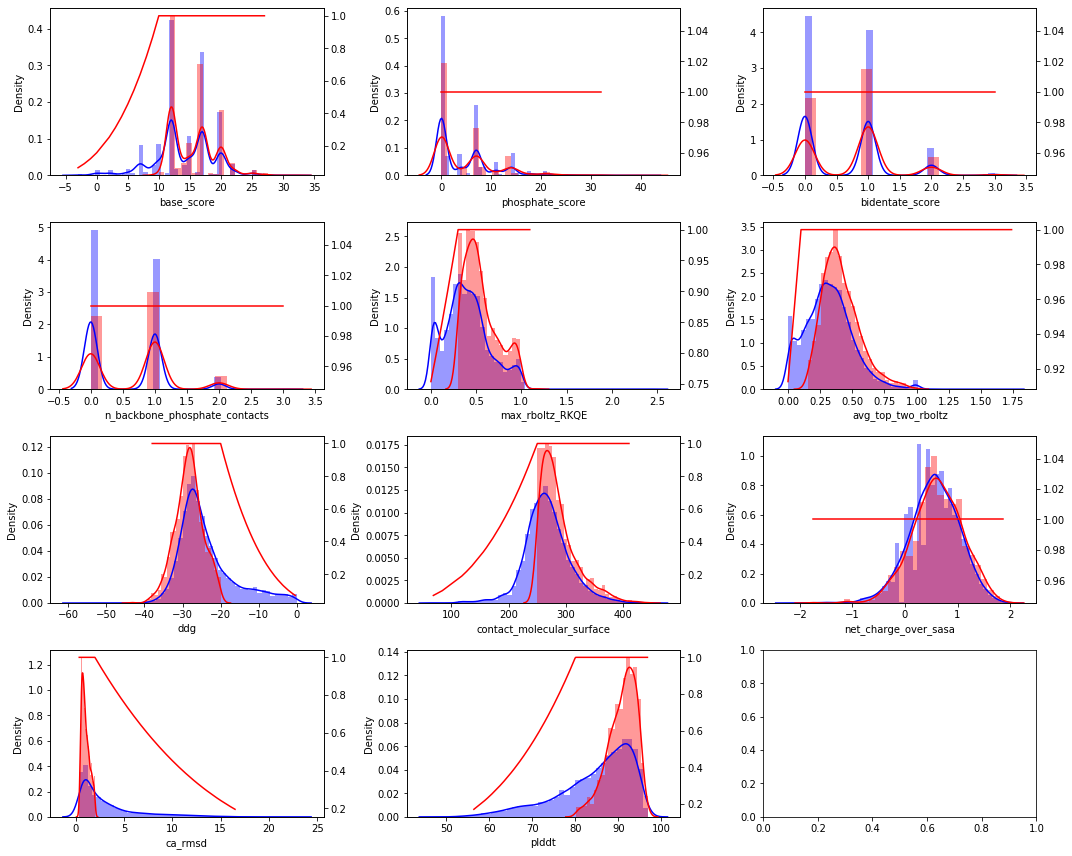


Order proposal: 1303 


In [11]:
# This cell filters the resulting outputs. You may play with filters to get a desired number of filtered outputs that look reasonable to you.
# You may change fraction not passing to allow some number of designs that are below the filter thresholds. 
# This is useful for testing if filters are helping in experiments.
# Use seqid_cut to cluster by sequence identify. seqid_cut of 1 will not cluster by sequence. 

fraction_not_passing = 0
seqid_cut = 1

df = pd.read_csv(f'{af2_path}/combined.csv')
df = df[df['ddg'] < 0]
df = df[df['ddg'] > -150]
df = df[df['contact_molecular_surface'] > 0]
df = df[df['max_rboltz_RKQE'] <= 1]

threshold_dict = {'base_score':[10,'>='],'phosphate_score':[0, '>='],'bidentate_score':[1, '>='],
                  'max_rboltz_RKQE':[0.1, '>='],'avg_top_two_rboltz':[0.1, '>='],'n_backbone_phosphate_contacts':[0,'>='],
                  'ddg':[-15,'<='],'contact_molecular_surface':[0,'>='],'net_charge_over_sasa':[-10,'>=']
                    }

df_filtered = useful_utils.filter_designs(mpnn2_path,df,threshold_dict,fraction_not_passing,seqid_cut)

In [12]:
SILENT_FILE = f'{af2_path}/combined.silent'

### Save passing designs.
selected_designs = []
for j in range(len(df_filtered)):
    selected_designs.append(str(df_filtered['out_tag'].iloc[j]))
print(len(selected_designs))


with open(f'{af2_path}/filtered_designs.list', 'w') as f:
    for line in selected_designs:
        f.write(line + '\n')
        
print('Run this in the terminal to get your filtered silent file:\n')
print(f"cat filtered_designs.list | silentslice {SILENT_FILE} > combined_filtered.silent")

df_filtered.to_csv(f'{af2_path}/combined_filtered.csv', index=False, header=True)

1303
Run this in the terminal to get your filtered silent file:

cat filtered_designs.list | silentslice /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022//combined.silent > combined_filtered.silent


In [65]:
print("""mkdir filtered_pdbs
cd filtered_pdbs
silentextract ../combined_filtered.silent""")

mkdir filtered_pdbs
cd filtered_pdbs
silentextract ../combined_filtered.silent


In [13]:
filtered_pdbs = glob.glob(f'{af2_path}/filtered_pdbs/*pdb')
print(len(filtered_pdbs))

1303


In [14]:
# Launches jobs that predict PWMs for each design. 

filtered_pdbs = glob.glob(f'{af2_path}/filtered_pdbs/*pdb')
cmds = f'{af2_path}/cmds_pwm'
results_dir = f'{af2_path}/filtered_pdbs/pwm_results/'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{af2_path}/pwm_logs/',exist_ok=True)
n=0
with open(cmds, 'w') as f:
    for pdb in filtered_pdbs:
        tag = pdb.split('/')[-1].replace('.pdb','')
        output_dir = f'{af2_path}/filtered_pdbs/pwm_results/{tag}/'
        output_file = f'{output_dir}/specific_pos_count.txt'
        if os.path.isfile(output_file): continue
        cmd = f'rm -r {output_dir}; \
                python /projects/protein-DNA-binders/scripts/pwm_from_ddg/pwm_from_ddg.py -i {pdb} -o {results_dir} -l 10 -s 2\n'
        f.write(cmd)
        n+=1

if os.path.exists('logs'): shutil.rmtree('logs')
env = '/home/cjg263/.conda/envs/cjg-pyrosetta'
jupyter_utils.make_submit_file(cmds=cmds, env=env, submitfile=cmds+'.sh', group_size=10, queue='cpu', timeout='24:00:00',cpus=1, mem='1G')
p = subprocess.Popen(['sbatch', cmds+'.sh'])
n_cmds = sum([1 for l in open(cmds,'r')])
print(f'Prepared and submitted {n_cmds} jobs for clustering in {cmds}')


cd /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022/
qlogin
conda deactivate
head -n1 cmds_pwm | bash



sbatch cmds_pwm.sh

Prepared and submitted 1303 jobs for clustering in /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022//cmds_pwm


In [21]:
# Generates dataframe with PWM and useless interface scores
pwm_score_fs = glob.glob(f'{af2_path}/filtered_pdbs/pwm_results/*/specific_pos_count.txt')
names = []
pwm_scores = []
on_target_pwm_scores = []
for pwm_score_f in pwm_score_fs:
    names.append(pwm_score_f.split('/')[-2])
    with open(pwm_score_f,'r') as f_in:
        lines = f_in.readlines()
        pwm_scores.append(int(lines[0].split(' ')[0]))
        on_target_pwm_scores.append(int(lines[0].split(' ')[1]))
pwm_score_dict = {'out_tag':names,'pwm_score':pwm_scores,'on_target_pwm_score':on_target_pwm_scores}
df_pwm_score = pd.DataFrame(pwm_score_dict)

df_designs = pd.read_csv(f'{af2_path}/combined_filtered.csv')
df_pwm_score = df_pwm_score.merge(df_designs, on='out_tag',how='inner')
print(len(df_pwm_score))
df_pwm_score.to_csv(f'{af2_path}/df_pwm.csv')

1291


1291 designs passing xml prefilters

filter hard_cut low_soft_cut_limit
----------------------------------
on_target_pwm_score 3 0.0
polar_fraction 0.5 0.667
base_score 10 8
phosphate_score 0 -2
bidentate_score 1 -1
max_rboltz_RKQE 0.3 -1.7
avg_top_two_rboltz 0.1 -1.9
n_backbone_phosphate_contacts 1 -1
ddg -25 -20.011
contact_molecular_surface 250 248
net_charge_over_sasa -10 -1.75
ca_rmsd 2 1.999
plddt 87.79 80.118

Hard cuts used to select orderable and setup the fuzzy cutoffs
--------------------------------------------------------------
           on_target_pwm_score:   3.00
                polar_fraction:   0.50
                    base_score:  10.00
               phosphate_score:   0.00
               bidentate_score:   1.00
               max_rboltz_RKQE:   0.30
            avg_top_two_rboltz:   0.10
 n_backbone_phosphate_contacts:   1.00
                           ddg: -25.00
     contact_molecular_surface: 250.00
          net_charge_over_sasa: -10.00
                       c

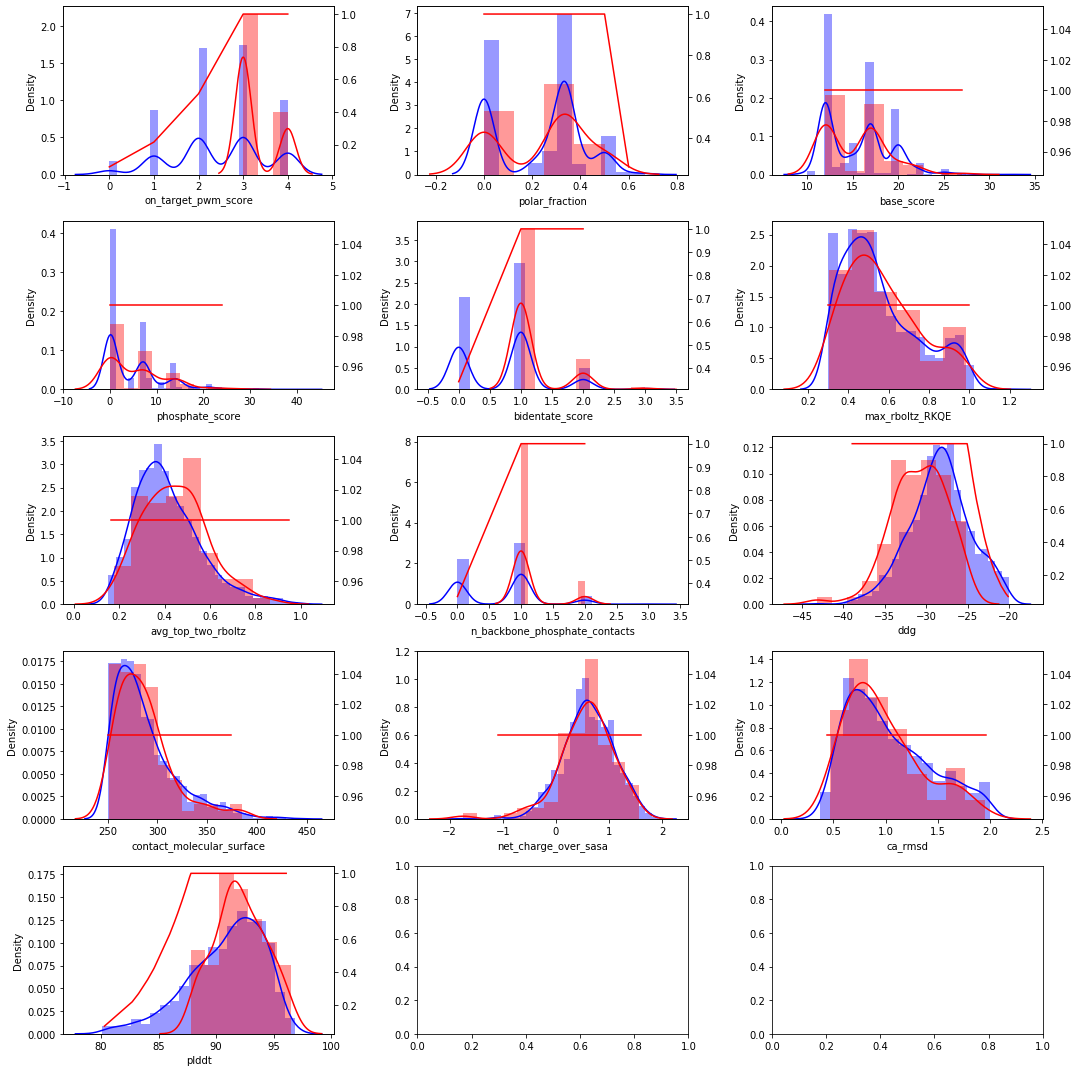


Order proposal: 96 


In [7]:
# This cell filters the resulting outputs. You may play with filters to get a desired number of filtered outputs that look reasonable to you.
# You may change fraction not passing to allow some number of designs that are below the filter thresholds. 
# This is useful for testing if filters are helping in experiments.
# Use seqid_cut to cluster by sequence identify. seqid_cut of 1 will not cluster by sequence. 

fraction_not_passing = 0
seqid_cut = 1

df = pd.read_csv(f'{af2_path}/df_pwm.csv')

threshold_dict = {'tot_on_tgt':[3.5,'>='],'on_target_pwm_score':[1,'>='],'base_score':[10,'>='],'phosphate_score':[0, '>='],'bidentate_score':[0, '>='],
                  'max_rboltz_RKQE':[0.1, '>='],'avg_top_two_rboltz':[0.1, '>='],'n_backbone_phosphate_contacts':[0,'>='],
                  'ddg':[-15,'<='],'contact_molecular_surface':[0,'>='],'net_charge_over_sasa':[-10,'>='],'ca_rmsd':[2,'<='],'plddt':[80,'>=']
                    }

df_filtered = useful_utils.filter_designs(mpnn2_path,df,threshold_dict,fraction_not_passing,seqid_cut)

In [8]:
SILENT_FILE = f'{af2_path}/combined_filtered.silent'

# These are your designs!!!
selected_designs = []
for j in range(len(df_filtered)):
    selected_designs.append(str(df_filtered['out_tag'].iloc[j]))
print(len(selected_designs))


with open(f'{af2_path}/pwm_filtered_designs.list', 'w') as f:
    for line in selected_designs:
        f.write(line + '\n')
        
print('Run this in the terminal to get your filtered silent file:\n')
print(f"""
cat pwm_filtered_designs.list | silentslice {SILENT_FILE} > combined_filtered_pwm.silent""")

df_filtered.to_csv(f'{af2_path}/combined_pwm_filtered.csv', index=False, header=True)

96
Run this in the terminal to get your filtered silent file:


cat pwm_filtered_designs.list | silentslice /net/scratch/cjg263/de_novo_dna/results/af2_superposiition/af2_ACCGGGACG_JUL2022//combined_filtered.silent > combined_filtered_pwm.silent
